# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name: Tajti Kristóf**  
**Neptun ID: XEL8MV**

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
# Fix to work on colab
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.17 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# ADD YOUR CODE HERE
import os
import re
import math
import torch
import logging
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from PIL import Image
from typing import List, Tuple
from collections import Counter
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [3]:
#!pip install -q kaggle

In [4]:
#!kaggle datasets download -d adityajn105/flickr8k

In [5]:
#!unzip flickr8k.zip -d flickr8k

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [6]:
# TODO - Create collanote for BPE for better understanding!
# NOTE - paralellization could be nice, but runs in 40s so its good for now
class Vocabulary:
    def __init__(self, freq_threshold, vocab_size=5000):
        self.freq_threshold = freq_threshold
        self.vocab_size = vocab_size # NOTE- maximum num of BPE merges
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} #index_to_string
        self.stoi = {v: k for k, v in self.itos.items()}  #string_to_index
        self.bpe_codes = {}
    
    def build_bpe_vocab(self, sentence_list: List[str]):
        logging.info('BPE vocab building started')
        self._build_initial_vocab(sentence_list)

        for i in range(self.vocab_size):
            if i == self.vocab_size:
                logging.INFO("MAX VOCAB_SIZE REACHED FOR BPE!")
            pairs = self._get_stats()
            if not pairs:
                break

            # NOTE - POINT OF STOPPING, check if best pairs work as intended
            best_pair = max(pairs, key=pairs.get)
            self._merge_pairs(best_pair)

        idx = 4 # start from 4 since tokens before are special ones, PAD SOS EOS UNK
        for word_tuple in self.word_freq:
            word = ''.join(word_tuple).replace('</w>', '')  #Remove end-of-word markers
            if word not in self.stoi:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
        logging.info('BPE vocab building finished')
        

    def numericalize(self, text: str):
        """
        Text to idxes
        """
        tokenized = self.tokenize(text)
        numericalized = []

        numericalized.append(self.stoi["<SOS>"])
        for token in tokenized:
            if token in self.stoi:
                numericalized.append(self.stoi[token])
            else:
                numericalized.append(self.stoi["<UNK>"])
        
        numericalized.append(self.stoi["<EOS>"])
        return numericalized

    def tokenize(self, text):
        tokens = []
        words = text.lower().split()
        for word in words:
            tokens.extend(self._apply_bpe(word))
        return tokens

    def _apply_bpe(self, word):
        if word in self.stoi:
            return [word]

        word_tuple = tuple(word) + ('</w>',)
        while True:
            pairs = [(word_tuple[i], word_tuple[i+1]) for i in range(len(word_tuple)-1)]
            candidate_pairs = {pair for pair in pairs if pair in self.bpe_codes}
            if not candidate_pairs:
                break
            best_pair = min(candidate_pairs, key=lambda pair: self.bpe_codes[pair])
            new_word = []
            i = 0
            while i < len(word_tuple):
                if i < len(word_tuple)-1 and (word_tuple[i], word_tuple[i+1]) == best_pair:
                    new_word.append(word_tuple[i] + word_tuple[i+1])
                    i += 2
                else:
                    new_word.append(word_tuple[i])
                    i += 1
            word_tuple = tuple(new_word)
        return [subword.replace('</w>', '') for subword in word_tuple]


    def _build_initial_vocab(self, sentence_list: List[str]):
        frequencies = Counter()
        for sentence in sentence_list:
            tokens = sentence.lower().split()
            frequencies.update(tokens)
        # with end of word token
        self.word_freq =  {tuple(word + ('</w>')): freq for word, freq in frequencies.items() if freq >= self.freq_threshold}

    def _get_stats(self):
        pairs = Counter()
        for word, freq in self.word_freq.items():
            for i in range(len(word)-1):
                pairs[(word[i], word[i+1])] += freq
        return pairs
    
    def _merge_pairs(self, pair: Tuple[str, str]):
        new_word_freq = {}
        bigram = re.escape(' '.join(pair)) # \ before special chars
        pattern = re.compile(r'(?<!\S)' + bigram + r'(?!\S)') # just putting bigram inbetween strs and making it re.Pattern obj 

        for word, freq in self.word_freq.items():
            # In all our words, we merge the pair into a single str pretty much
            new_word = tuple(re.sub(pattern, ''.join(pair), ' '.join(word)).split())
            new_word_freq[new_word] = freq

        self.word_freq = new_word_freq
        self.bpe_codes[pair] = len(self.bpe_codes)

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5): #generous hint
        self.root_dir = root_dir
        self.captions_file = captions_file # NOTE - do we need this?
        self.transform = transform
        self.vocabulary = Vocabulary(freq_threshold)
        self.captions_df = pd.read_csv(captions_file)
        self.vocabulary.build_bpe_vocab(list(self.captions_df['caption']))


    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        image_name = self.captions_df['image'][idx]
        caption = self.captions_df['caption'][idx]
        image = Image.open(os.path.join(self.root_dir, "Images", image_name)) # Tiny bit of hardcoding
        if self.transform is not None:
            image = self.transform(image)
        caption_vec = self.vocabulary.numericalize(caption)
        return image, torch.tensor(caption_vec) #generous hint
    
    # for batching compatibility

def collate_fn(batch):
    images = []
    captions = []

    for img, cap in batch:
        images.append(img)
        captions.append(cap)

    images = torch.stack(images, dim=0)
    captions = pad_sequence(captions, batch_first=True, padding_value=0) # since pad idx is 0

    return images, captions

In [ ]:
# NOTE - could be useful to add normalization later on!
transforms = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])

flickr_dataset = FlickrDataset('flickr8k', 'flickr8k/captions.txt', transform=transforms)

INFO:root:BPE vocab building started


Example output from dataset class

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/

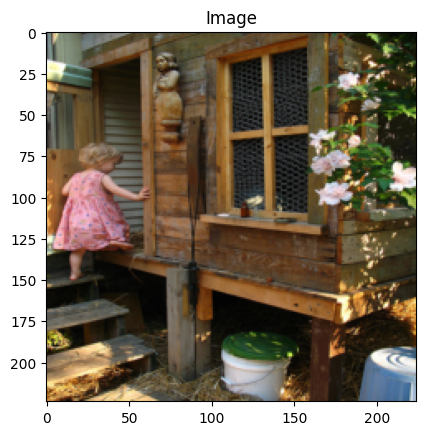

Token: tensor([  1,   4,   5,   6,   4,   7,   8,   9,  10,  11,   4,  12,  13,  14,
          6,  15,   3, 897,  16,  17,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'try', 'way', '.', '<EOS>']


In [ ]:
# ADD YOUR CODE HERE
# Show some visualizations of the created dataset
def show_image(image, title: str) -> None:
    plt.imshow(np.array(image.permute(1, 2, 0)))
    plt.title(title)
    plt.show()

img, caps = flickr_dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([flickr_dataset.vocabulary.itos[token] for token in caps.tolist()])

Split your dataset into train, val and test sets

In [ ]:
# ADD YOUR CODE HERE
# split like this due to the small size of the dataset, might need resplit idk
train_set, val_set, test_set = torch.utils.data.random_split(flickr_dataset, [0.8, 0.1, 0.1])

Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

In [ ]:
# ADD YOUR CODE HERE
# Example with batch=4
train_loader = DataLoader(
    dataset=train_set,
    batch_size=128,
    shuffle=True,
    num_workers=16,
    collate_fn=collate_fn 
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=128,
    shuffle=False,
    num_workers=16,
    collate_fn=collate_fn 
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=128,
    shuffle=False,
    num_workers=16,
    collate_fn=collate_fn 
)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(

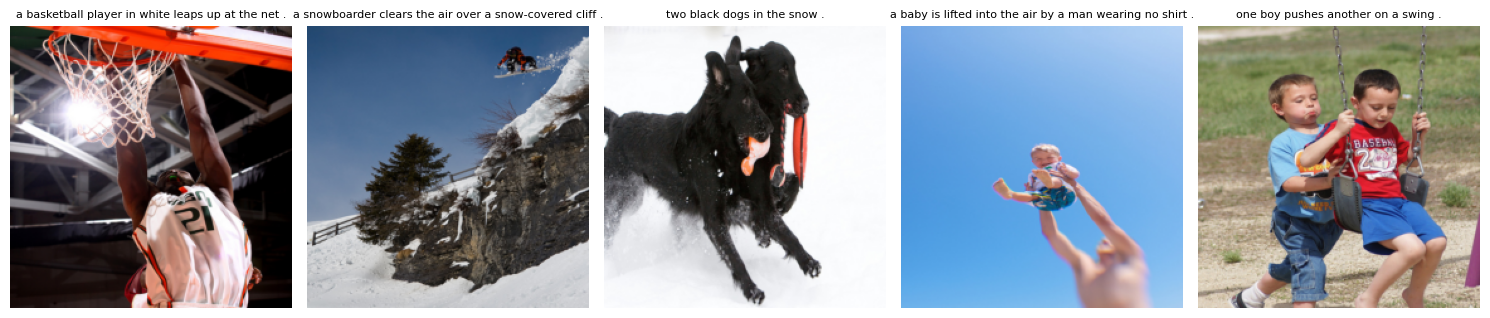

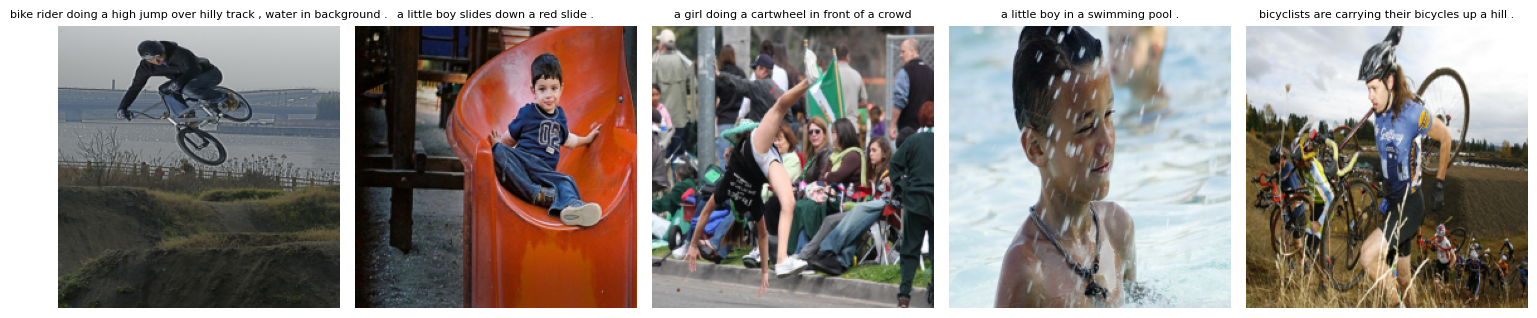

In [ ]:
def show_images_with_captions(images, captions, vocabulary, num_images=5):
    images = images.cpu()
    captions = captions.cpu()
    num_images = min(num_images, images.size(0))
    _, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes]

    for img_idx in range(num_images):
        image = images[img_idx]
        caption = captions[img_idx]
        image = image.permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)

        caption_indices = caption.tolist()
        caption_tokens = []
        for token_idx in caption_indices:
            token = vocabulary.itos.get(token_idx, "<UNK>")
            if token in ["<PAD>", "<SOS>", "<EOS>"]:
                continue
            caption_tokens.append(token)
        caption_text = ' '.join(caption_tokens)

        axes[img_idx].imshow(image)
        axes[img_idx].axis('off')
        axes[img_idx].set_title(caption_text, fontsize=8)

    plt.tight_layout()
    plt.show()


iters_to_show = 1
for idx, (images, captions) in enumerate(train_loader):
    show_images_with_captions(images, captions, flickr_dataset.vocabulary)
    if idx >= iters_to_show:
        break

#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [ ]:
#Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [ ]:
# NOTE - could play around with implementing VIT from scratch!
# ADD YOUR CODE HERE
import timm

class Encoder(nn.Module):
    def __init__(self, embed_dim):
        super(Encoder, self).__init__()
        # Create the ViT model with required configurations
        self.vit = timm.create_model(
            'vit_base_patch16_224',
            pretrained=True,
            num_classes=0,  # Removes the classification head
            global_pool=''  # Prevents global pooling
        )
        self.embed_dim = embed_dim
        if self.vit.embed_dim != embed_dim:
            self.linear = nn.Linear(self.vit.embed_dim, embed_dim)
        else:
            self.linear = nn.Identity()

    def forward(self, images):
        # Extract features
        features = self.vit(images)  # Now returns per-patch embeddings
        print(f"Features shape: {features.shape}")  # For debugging
        features = self.linear(features)  # Project to desired embed_dim if necessary
        return features 

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# NOTE - add collanote about pos encoding!
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x


In [ ]:
# NOTE - create image of how it looks like exactly!
class Decoder(nn.Module):
    def __init__(self, embed_dim, vocab_size, num_layers, num_heads, dim_feedforward, dropout):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, tgt, memory, tgt_mask=None, tgt_padding_mask=None):
        tgt_emb = self.embedding(tgt) * math.sqrt(self.embed_dim)
        tgt_emb = self.pos_encoder(tgt_emb)
        tgt_emb = self.dropout(tgt_emb)
        
        tgt_emb = tgt_emb.transpose(0, 1)
        memory = memory.transpose(0, 1)
        
        output = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)
        output = output.transpose(0, 1)  # batch_size, seq_len, embed_dim
        output = self.fc_out(output)  # batch_size, seq_len, vocab_size
        return output


Combine the encoder - attention - decoder

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_dim, vocab_size, num_decoder_layers, num_heads, dim_feedforward, dropout):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(embed_dim)
        self.decoder = Decoder(embed_dim, vocab_size, num_decoder_layers, num_heads, dim_feedforward, dropout)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

    def forward(self, images, captions):
        encoder_outputs = self.encoder(images)
        
        tgt_mask = self.generate_square_subsequent_mask(captions.size(1)).to(captions.device)
        tgt_padding_mask = captions == 0

        outputs = self.decoder(
            captions,
            encoder_outputs,
            tgt_mask=tgt_mask,
            tgt_padding_mask=tgt_padding_mask
        )
        return outputs


### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

In [ ]:
model = ImageCaptioningModel(embed_dim=512, vocab_size=len(flickr_dataset.vocabulary.stoi), num_decoder_layers=4, num_heads=4, dim_feedforward=4*768, dropout=0.1).to(device) 

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/11" 302 0
INFO:timm.models._hub:[timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [ ]:
print(model)

ImageCaptioningModel(
  (encoder): Encoder(
    (vit): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=

In [ ]:
model_total_params = sum(p.numel() for p in model.parameters())
model_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'total params: {model_total_params}')
print(f'trainable params: {model_total_params}')

total params: 110287037
trainable params: 110287037


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=flickr_dataset.vocabulary.stoi['<PAD>'])

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch} started')
    model.train()
    total_loss = 0
    for images, captions in train_loader:
        images = images.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        
        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]
        outputs = model(images, captions_input)
        
        outputs = outputs.view(-1, outputs.size(-1))
        captions_target = captions_target.reshape(-1)
        loss = criterion(outputs, captions_target)
  
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # had some inf es without it
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch 0 started
Features shape: torch.Size([128, 197, 768])
Encoder outputs shape: torch.Size([128, 197, 512])
tgt_mask shape: torch.Size([27, 27])
tgt_padding_mask shape: torch.Size([128, 27])


/usr/local/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Features shape: torch.Size([128, 197, 768])
Encoder outputs shape: torch.Size([128, 197, 512])
tgt_mask shape: torch.Size([31, 31])
tgt_padding_mask shape: torch.Size([128, 31])
Features shape: torch.Size([128, 197, 768])
Encoder outputs shape: torch.Size([128, 197, 512])
tgt_mask shape: torch.Size([31, 31])
tgt_padding_mask shape: torch.Size([128, 31])
Features shape: torch.Size([128, 197, 768])
Encoder outputs shape: torch.Size([128, 197, 512])
tgt_mask shape: torch.Size([34, 34])
tgt_padding_mask shape: torch.Size([128, 34])
Features shape: torch.Size([128, 197, 768])
Encoder outputs shape: torch.Size([128, 197, 512])
tgt_mask shape: torch.Size([28, 28])
tgt_padding_mask shape: torch.Size([128, 28])
Features shape: torch.Size([128, 197, 768])
Encoder outputs shape: torch.Size([128, 197, 512])
tgt_mask shape: torch.Size([30, 30])
tgt_padding_mask shape: torch.Size([128, 30])
Features shape: torch.Size([128, 197, 768])
Encoder outputs shape: torch.Size([128, 197, 512])
tgt_mask shape:

KeyboardInterrupt: 

In [ ]:
# ADD YOUR CODE HERE
#Example of how to save a model (call this in the training loop)
def save_model(model,num_epochs):
    model_state = {
        'embed_size':embed_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'image_captioning.pth')

#In case of resuming training, make sure to load the architecture first
# model = Architecture()
#and then load the weights and other params
# model.load_state_dict(model_state['state_dict'])

Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

In [ ]:
model = ...
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

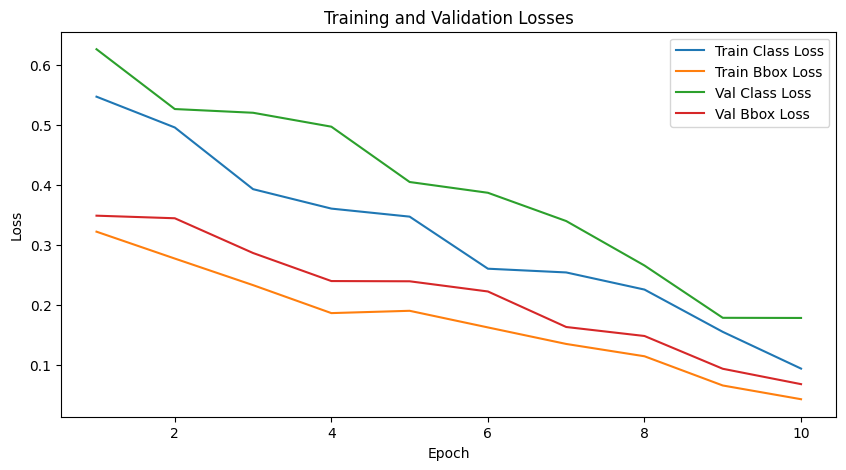

In [ ]:
# ADD YOUR CODE HERE


train_losses, val_losses = train_model(...)
plot_losses(train_losses, val_losses)
# DO NOT TRY TO REPLICATE... this is an example

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


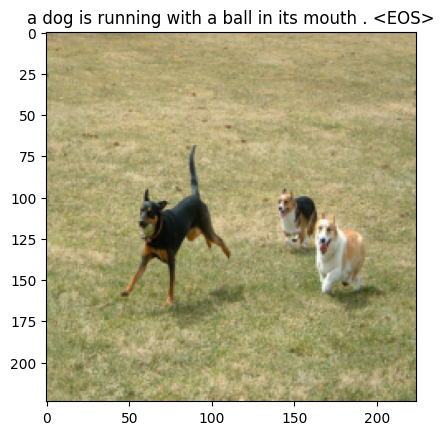

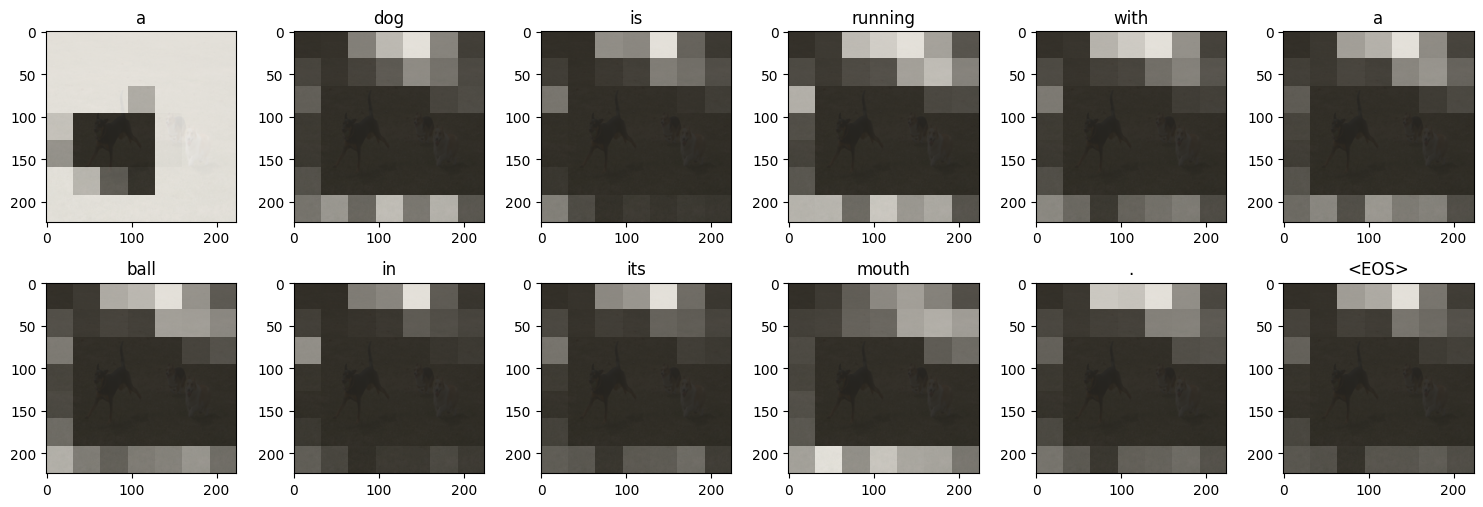

In [ ]:
# ADD YOUR CODE HERE

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [ ]:
# ADD YOUR CODE HERE

### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

In [ ]:
# ADD YOUR CODE HERE

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

In [ ]:
# ADD YOUR CODE HERE

# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

In [ ]:
# ADD YOUR CODE HERE